# Fit NuSTAR FPMA and FPMB simultaneously: single thermal component, no pileup correction, no gain correction

Here we demonstrate how one may perform simultaneous spectral fitting with the two NuSTAR detectors.

The NuSTAR data fit here is a quiet Sun brightening on 8 Jan 2021 11:57:25UTC to 11:59:23UTC, orbit ID 20612002001, grades 0-4.

We supply the data from the pipeline as an ASDF file which may be downloaded from [here](https://drive.google.com/file/d/19BeSwSACum5lb0TE9BN7dyos91XP5L3O).

The procedure is basically as follows:
1. Load the data for each detector into a `fitting.DataPacket`.
2. Construct a `fitting.BayesFitter` or some other kind of fitting object for each detector:
    - Give each the proper data packet
    - Give each a set of parameters, log priors, model, and log likelihood.
      In this example we use a Poisson likelihood and single thermal model.
      There are several bins with only ~1-5 counts so the difference between
      Poisson statistics and Gaussian statistics is significant.
3. Minimize each data set individually using Levenberg-Marquadt least squares (like XSPEC)
    - This gives a good starting guess for the composite minimization
4. Construct a `fitting.CompositeBayesFitter` which coordinates parameter sharing between the two `BayesFitter`s. During this construction, you must supply a set of parameters which are shared between the models in each `BayesFitter`.
5. Run `emcee` on the Composite fitter.

If you want to fit different energy ranges with the models, modify the log likelihoods (at any time) to adjust the fit range under consideration.

**If you want to perform a "fancy" parameter transformation,** put it in your model function. The "shared" parameters get the same _values_ passed to the model functions, but the model functions themselves may scale or operate on them however necessary. For example, if you want to fit something where a parameter is twice the temperature of the "shared" temperature, just add the factor of 2 in the model function.

In [1]:
import os

# Set this so that matrix multiplication doesn't take up too many CPU cores
os.environ["OMP_NUM_THREADS"] = "8"

import asdf
import astropy.units as u
import corner

%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("nice.mplstyle")

import numpy as np

import yaff.fitting as fitting
from yaff import plotting as yap
from yaff import common_likelihoods
from yaff.common_models import thermal

## Define the model parameters and their priors (aka bounds in this case)

In [2]:
# Define the parameters with their initial guesses (all free to start)
starting_parameters = {
    "temperature": fitting.Parameter(10 << u.MK, frozen=False),
    "emission_measure": fitting.Parameter(2 << (1e44 * u.cm**-3), frozen=False),
}

# The priors we give are just "bounds" on
# the physical values. They could be something
# more interesting like a truncated normal,
# or some other probability distribution.
log_priors = {
    "temperature": fitting.simple_bounds(0, 100),
    "emission_measure": fitting.simple_bounds(0, 1000),
}

## Load in all of the data into "packets"

In [3]:
data_packs: list[fitting.DataPacket] = list()

with asdf.open("nustar_example.asdf") as af:
    for fpm in ("FPMA", "FPMB"):
        this_dat = af[fpm]
        data_packs.append(
            fitting.DataPacket(
                counts=this_dat["counts"],
                counts_error=this_dat["counts_error"],
                background_counts=this_dat["background_counts"],
                background_counts_error=this_dat["background_counts_error"],
                effective_exposure=this_dat["effective_exposure"],
                count_energy_edges=this_dat["count_energy_edges"],
                photon_energy_edges=this_dat["photon_energy_edges"],
                response_matrix=this_dat["response_matrix"],
            )
        )

/home/william/dev/yaff/yaff/fitting.py:94: UserWarning: 
Your response matrix is square.
Make sure it is oriented properly, C = (SRM @ P).
Can't tell from photon vs count edge shapes
  warnings.warn(


## For this event, we need to use a Poisson likelihood (or an approximation thereof) because we have very few counts in some bins.

In [4]:
# Fit only a small energy range
# The data pack energy units default to keV
mids = data_packs[0].count_energy_mids
restrict = (2.5 <= mids) & (mids <= 5)
log_likelihood = common_likelihoods.poisson_factory(restrict)

## Construct `BayesFitter`s for both focal plane module A (FPMA) and FPMB
Here we assume there is no background (this is a quiet Sun brightening),
and we also assume that the model is exactly the same between them (single thermal).

If we wanted to have separate models we would have to assign one of the fitters that model.
Not a problem, just something to be aware of.

In [5]:
# Load in the data output from the NuSTAR pipeline
fitters: list[fitting.BayesFitter] = []
for dp in data_packs:
    # Add a fitter with the current data packet
    fitters.append(
        fitting.BayesFitter(
            data=dp,
            model_function=thermal,
            parameters=starting_parameters,
            log_priors=log_priors,
            log_likelihood=log_likelihood,
        )
    )

## Now that the data is loaded and parameters are set up, minimize them using Levenberg-Marquadt like XSPEC to get them close to the "true" best parameters

In [6]:
import importlib

importlib.reload(fitting)
# Minimize individually with levenberg-marquadt
fita, fitb = fitters

_ = fitting.levenberg_minimize(fita)
_ = fitting.levenberg_minimize(fitb)

fita.parameters, fitb.parameters

/home/william/dev/yaff/yaff/fitting.py:580: RuntimeWarning: divide by zero encountered in divide
  ret = (mod - compare) / total_error
/home/william/dev/yaff/yaff/fitting.py:580: RuntimeWarning: invalid value encountered in divide
  ret = (mod - compare) / total_error


(OrderedDict([('temperature', Parameter(3.70e+00, MK, frozen=False)),
              ('emission_measure',
               Parameter(2.27e+00, 1e+44 / cm3, frozen=False))]),
 OrderedDict([('temperature', Parameter(3.74e+00, MK, frozen=False)),
              ('emission_measure',
               Parameter(1.74e+00, 1e+44 / cm3, frozen=False))]))

## Plot the current "best fits" to see how things are doing

/home/william/dev/yaff/yaff/plotting.py:65: RuntimeWarning: divide by zero encountered in divide
  residual = (data - count_model - bkg) / np.sqrt(err**2 + bkg_err**2)
/home/william/dev/yaff/yaff/plotting.py:65: RuntimeWarning: invalid value encountered in divide
  residual = (data - count_model - bkg) / np.sqrt(err**2 + bkg_err**2)


[Text(0.5, 1.0, 'FPMB fit (black) vs data (blue)')]

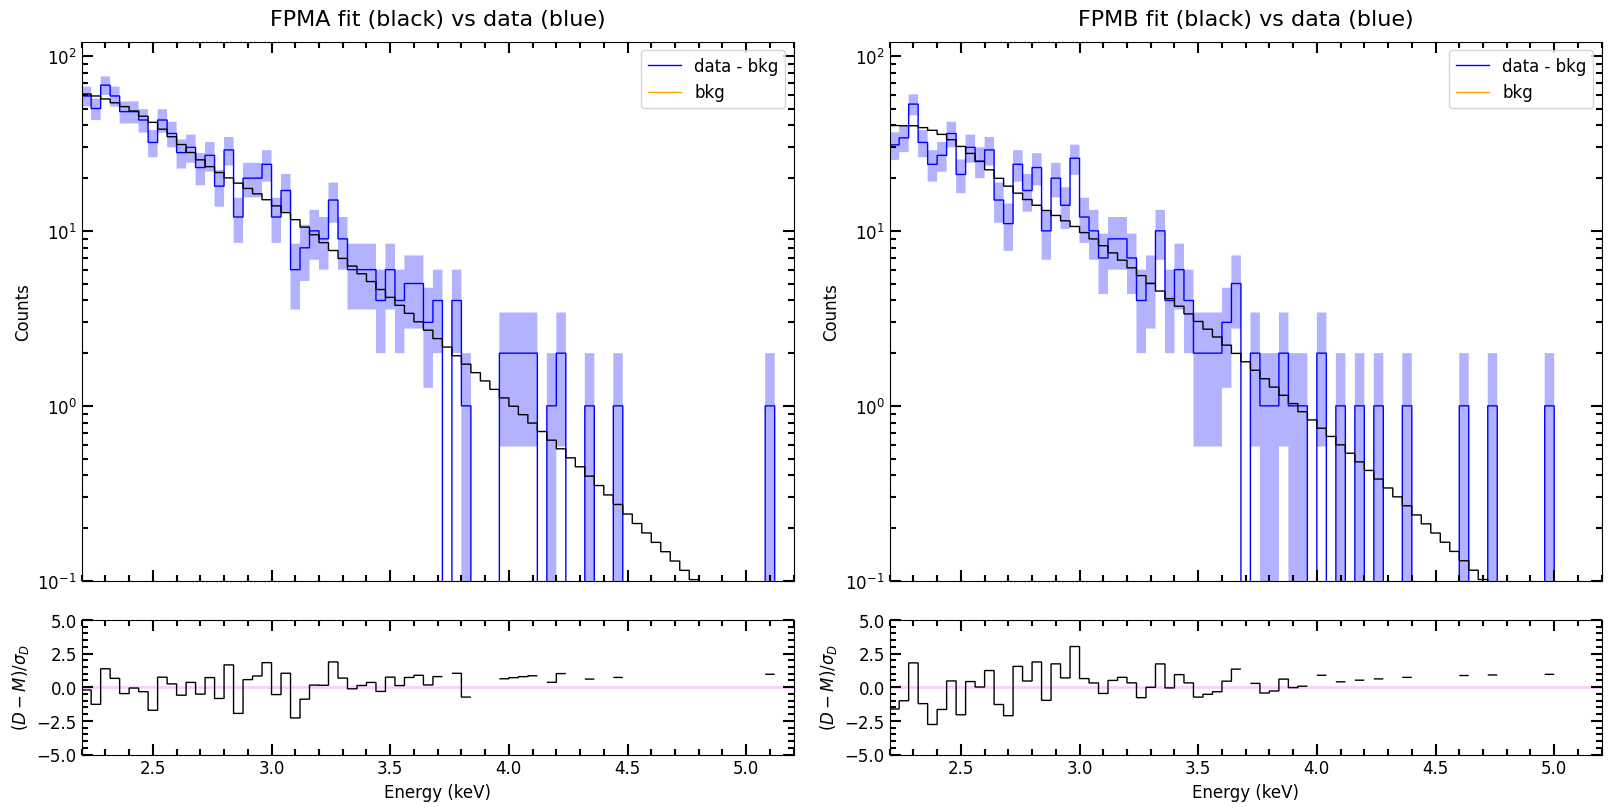

In [7]:
importlib.reload(yap)
fig = plt.figure(figsize=(16, 8))
figa, figb = fig.subfigures(nrows=1, ncols=2)

reta = yap.plot_data_model(fita, [fita.eval_model()], fig=figa)
retb = yap.plot_data_model(fitb, [fitb.eval_model()], fig=figb)

for dat in (reta, retb):
    dat["data_ax"].set(xlim=(2.2, 5.2), xscale="linear", ylim=(0.1, 120))

reta["data_ax"].set(title="FPMA fit (black) vs data (blue)")
retb["data_ax"].set(title="FPMB fit (black) vs data (blue)")

## Build the composite fitter out of the two `BayesFitter`s, indicating that `temperature` is the only shared parameter.

In [8]:
# Set up a composite fitter where both parameters are shared
# between the models
composite = fitting.CompositeBayesFitter(
    individual_fitters=fitters, shared_param_names=["temperature"]
)

# Constrain the temperature, but let the emission measures vary independently.
composite.shared_params["temperature"].frozen = False

# Parameters are associated with sub-fitters, or they are shared
composite.parameters

{'shared': OrderedDict([('temperature',
               Parameter(3.70e+00, MK, frozen=False))]),
 'fitter 0': {'emission_measure': Parameter(2.27e+00, 1e+44 / cm3, frozen=False)},
 'fitter 1': {'emission_measure': Parameter(1.74e+00, 1e+44 / cm3, frozen=False)}}

### We already have a good starting guess, so cut to the chase with MCMC

In [9]:
composite.run_emcee({"nwalkers": 16}, {"nsteps": 500, "progress": True})

# Save the object if you want for later retrieval
# It gets "pickled" with the `dill` library which is more versatile
# import lzma
# composite.save('nustar-composite.dill.xz', open_func=lzma.open)

100%|██████████| 500/500 [09:05<00:00,  1.09s/it]


## Plot the resulting parameter chains

{'fig': <Figure size 800x600 with 3 Axes>,
 'axes': [<Axes: title={'center': 'temperature'}, ylabel='MK'>,
  <Axes: title={'center': 'emission_measure'}, ylabel='1e+44 / cm3'>,
  <Axes: title={'center': 'emission_measure'}, ylabel='1e+44 / cm3'>]}

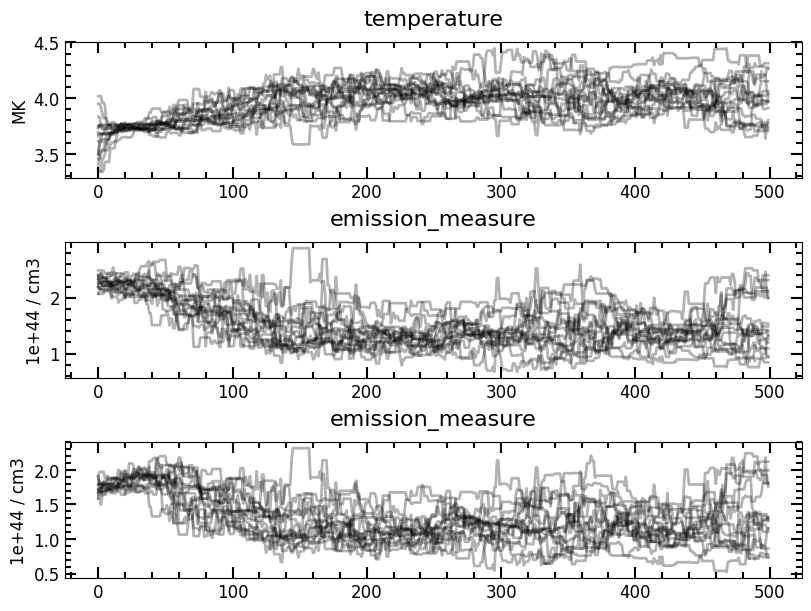

In [10]:
yap.plot_parameter_chains(
    fitter=composite, names=composite.free_param_names, params=composite.free_parameters
)

## Generate a few model samples from the MCMC parameters, after "burning-in" the MCMC chains

In [11]:
flat = composite.emcee_sampler.flatchain.T
# For the flattened chain we need to multiply by
# the number of walkers (stored in shape[0])
burn = 200 * composite.emcee_sampler.chain.shape[0]
tch, em_ach, em_bch = flat[:, burn:]

num = 50
rng = np.random.default_rng()
fpma_samples = rng.choice(np.array((tch, em_ach)).T, size=num)
fpmb_samples = rng.choice(np.array((tch, em_bch)).T, size=num)

fita, fitb = fitters

fpma_mods = list()
for t, em in fpma_samples:
    fita.parameters["temperature"].value = t
    fita.parameters["emission_measure"].value = em
    fpma_mods.append(fita.eval_model())

fpmb_mods = list()
for t, em in fpmb_samples:
    fitb.parameters["temperature"].value = t
    fitb.parameters["emission_measure"].value = em
    fpmb_mods.append(fitb.eval_model())

## Plot the model samples on top of the data

/home/william/dev/yaff/yaff/plotting.py:65: RuntimeWarning: divide by zero encountered in divide
  residual = (data - count_model - bkg) / np.sqrt(err**2 + bkg_err**2)
/home/william/dev/yaff/yaff/plotting.py:65: RuntimeWarning: invalid value encountered in divide
  residual = (data - count_model - bkg) / np.sqrt(err**2 + bkg_err**2)


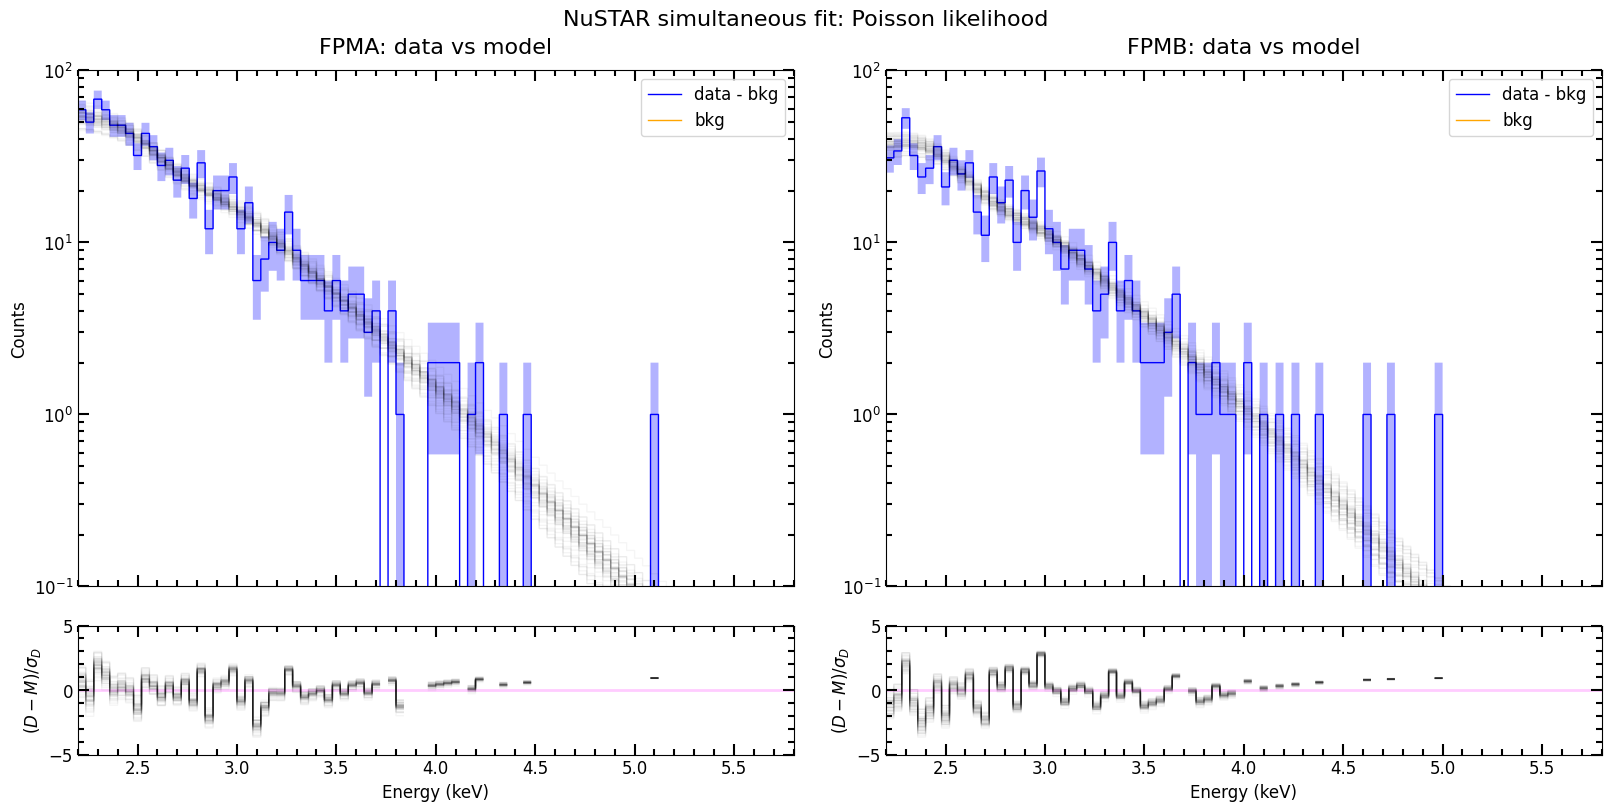

In [12]:
# Give each focal plane module a figure
fig = plt.figure(figsize=(16, 8))
figa, figb = fig.subfigures(nrows=1, ncols=2)

reta = yap.plot_data_model(fita, fpma_mods, figa)
reta["data_ax"].set(title="FPMA: data vs model")

retb = yap.plot_data_model(fitb, fpmb_mods, figb)
retb["data_ax"].set(title="FPMB: data vs model")

for r in reta, retb:
    r["data_ax"].set(ylim=(1e-1, 1e2), xlim=(2.2, 5.8), xscale="linear")

fig.suptitle("NuSTAR simultaneous fit: Poisson likelihood")
None

## Make corner plots of the parameters we found

/tmp/ipykernel_11751/1303778972.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


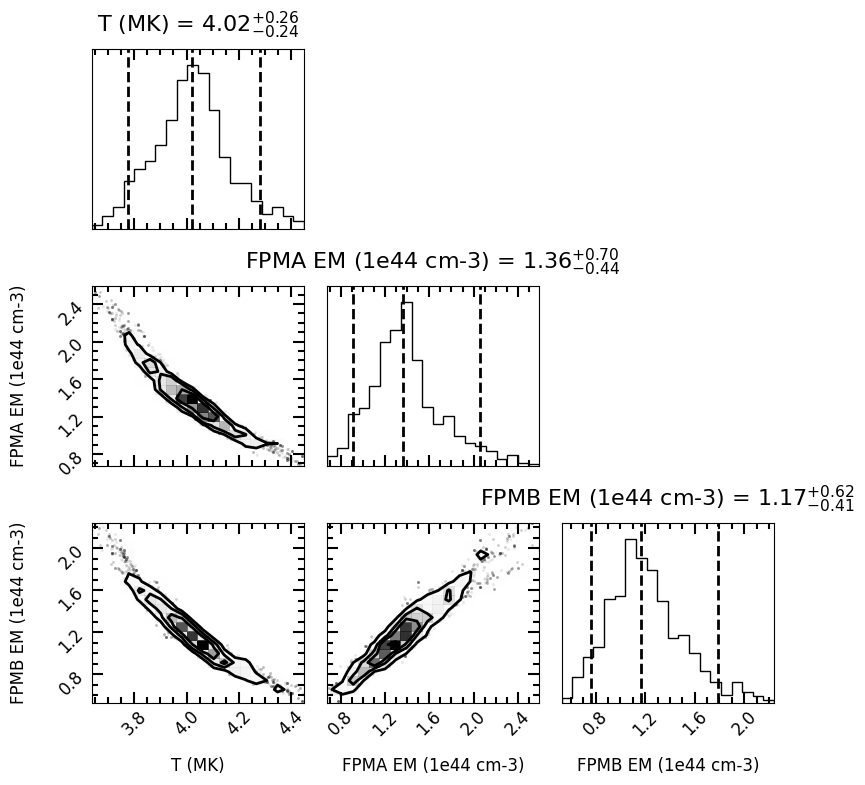

In [13]:
burned_flatchain = composite.emcee_sampler.flatchain[burn:]
param_names = ["T (MK)", "FPMA EM (1e44 cm-3)", "FPMB EM (1e44 cm-3)"]

fig = plt.figure(figsize=(8, 8), layout="tight")
corner.corner(
    burned_flatchain,
    bins=20,
    labels=param_names,
    show_titles=True,
    fig=fig,
    # 90% credible intervals annotated
    quantiles=(0.05, 0.5, 0.95),
)
fig.show()

## The FPMA/B emission measures are almost the same and correlate 1:1